# Imports

In [1]:
import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg 
from scipy.special import binom
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
from sklearn.metrics import f1_score
from utils import *
from williams import williams_test

# Data visualization

In [2]:
ANNOTATIONS_DF = pd.read_csv("hanna_stories_annotations.csv")
METRICS_DF = pd.read_csv("hanna_metric_scores.csv", index_col="Model")

In [3]:
CORRELATIONS = {
    "pearson": pearsonr,
    "spearman": spearmanr,
    "kendall": kendalltau
}
CORRELATION_TYPES = ["story", "system"]

CRITERIA = ['Relevance', 'Coherence', 'Empathy', 'Surprise', 'Engagement', 'Complexity']
CRITERIA_LABELS = ["RE", "CH", "EM", "SU", "EG", "CX"]

N_STORIES = 96

MODELS = [
    "Human",
    "BertGeneration",
    "CTRL",
    "GPT",
    "GPT-2 (tag)",
    "GPT-2",
    "RoBERTa",
    "XLNet",
    "Fusion",
    "HINT",
    "TD-VAE"
]

METRICS = METRICS_DF.columns[6:].tolist()

METRICS_FILTERED = [
    "BLEU Ξ§", "ROUGE-1 Recall Ξ§",
    "METEOR Ξ§", "chrF Ξ§", "ROUGE-WE-3 Recall Ξε", "BERTScore Recall Ξε",
    "MoverScore Ξε", "DepthScore Ξε", "BaryScore-W Ξε", "S3-Pyramid ΞΔ", "SummaQA ΞΔ", 
    "InfoLM-FisherRao ΞΔ", "BARTScore-SH ΞΔ",
    "Coverage ¤§", "Repetition-1 ¤§",
    "SUPERT-PS ¤ε", "BLANC-Tune-PS ¤Δ"
]

METRICS_FILTERED_LABELS = [
    "BLEU Ξ§", "ROUGE-1 Ξ§",
    "METEOR Ξ§", "chrF Ξ§", "ROUGE-WE-3 Ξε", "BERTScore Ξε",
    "MoverScore Ξε", "DepthScore Ξε", "BaryScore Ξε", "S3 ΞΔ", "SummaQA ΞΔ", 
    "InfoLM ΞΔ", "BARTScore ΞΔ",
    "Coverage ¤§", "Repetition-1 ¤§",
    "SUPERT ¤ε", "BLANC ¤Δ"
]

METRICS_FILTERED_DF = METRICS_DF[CRITERIA+METRICS_FILTERED]  # contains fewer metrics
METRICS_FILTERED_DF.columns = CRITERIA+METRICS_FILTERED_LABELS
METRICS_DF_NO_HUMAN = METRICS_DF.drop(["Human"])
METRICS_FILTERED_DF_NO_HUMAN = METRICS_FILTERED_DF.drop(["Human"])

In [3]:
ANNOTATIONS_DF

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Worker ID,Assignment ID,Work time in seconds,Name
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,4,4,3,2,4,4,A2VE5IV9OD2SK1,3X87C8JFVHIT235KQ4UTS8264I6SQJ,579.0,None
1,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,5,5,1,3,4,1,A1IZ4NX41GKU4X,3DR23U6WEGL5K0SU6D4J8W9EM9LTE7,82.0,none
2,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,2,2,3,2,2,3,A264NN7JBX4UDQ,3UJ1CZ6IZSW49HMM6C6QUX7F7UV5SA,273.0,none
3,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,5,3,4,4,4,A3CFNUD7VR2E1E,317HQ483IIZJ5SPW508YKC1EP6RINX,117.0,Eric
4,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,4,4,4,4,4,A2VE5IV9OD2SK1,3T3IWE1XGHUUH3IZF4ZJ2DYS57WQTT,751.0,Eric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1054,"When a new president is elected, they are give...",“Mr President I want you to know I am telling ...,'said a puppet'President Bush stopped the old ...,TD-VAE,2,1,1,3,2,2,A2WNW8A4MOR7T7,3QHK8ZVMIXPJUK85ND02LXTCPDOBLG,140.0,Bush
3164,1054,"When a new president is elected, they are give...",“Mr President I want you to know I am telling ...,'said a puppet'President Bush stopped the old ...,TD-VAE,3,2,3,2,2,3,A264NN7JBX4UDQ,3RANCT1ZVQOMDAVZWRS3CKPV2N6BU1,467.0,none
3165,1055,You discover a grand hall filled with legendar...,"Waking with a start, my blankets strewn wildly...",It is YOU. Your mother's greatest love.”...'Oh...,TD-VAE,3,4,2,2,3,3,A1IZ4NX41GKU4X,3ATTHHXXWLVOHM3076V7IESCSB5IX4,65.0,mother
3166,1055,You discover a grand hall filled with legendar...,"Waking with a start, my blankets strewn wildly...",It is YOU. Your mother's greatest love.”...'Oh...,TD-VAE,2,5,5,5,5,5,A264NN7JBX4UDQ,3F6KKYWMNM82XH9ADM7NTFL1XCJNDM,214.0,none


In [4]:
METRICS_DF

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,BLEU Ξ§,ROUGE-1 Recall Ξ§,ROUGE-1 Precision Ξ§,ROUGE-1 F-Score Ξ§,...,Repetition-2 ¤§,Repetition-3 ¤§,SUPERT-PS ¤ε,SUPERT-SS ¤ε,BLANC-Tune-PS ¤Δ,BLANC-Help-PS ¤Δ,BLANC-Tune-SS ¤Δ,BLANC-Help-SS ¤Δ,BARTScore-PS ¤Δ,BARTScore-SP ¤Δ
Model,,,,,,,,,,,,,,,,,,,,,
Human,"[3.6666666666666665, 5.0, 4.666666666666667, 3...","[3.6666666666666665, 4.666666666666667, 4.6666...","[2.3333333333333335, 4.0, 4.0, 3.0, 3.0, 3.333...","[2.3333333333333335, 3.6666666666666665, 4.333...","[3.3333333333333335, 3.6666666666666665, 4.0, ...","[2.6666666666666665, 4.0, 4.333333333333333, 4...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.10407239819004525, 0.1198501872659176, 0.07...","[0.029288702928870293, 0.03691275167785235, 0....","[0.36060585433665243, 0.30589759827771107, 0.2...","[0.3513956792291503, 0.3298352311450941, 0.273...","[0.0, 0.040983606557377046, -0.011111111111111...","[-0.02608695652173913, 0.0, -0.011111111111111...","[0.058823529411764705, -0.14285714285714285, 0...","[-0.23529411764705882, -0.14285714285714285, 0...","[-4.046356201171875, -4.839603424072266, -4.85...","[-4.624497413635254, -6.575280666351318, -4.77..."
BertGeneration,"[1.6666666666666667, 3.0, 1.3333333333333333, ...","[3.6666666666666665, 2.6666666666666665, 2.333...","[2.6666666666666665, 2.6666666666666665, 1.0, ...","[1.3333333333333333, 2.0, 1.6666666666666667, ...","[2.6666666666666665, 2.6666666666666665, 1.333...","[2.6666666666666665, 2.6666666666666665, 1.333...","[1.4336111822, 1.4493826988, 0.1779090484, 0.1...","[0.38249, 0.24074, 0.16285, 0.13276, 0.40645, ...","[0.37054, 0.26639, 0.59259, 0.56771, 0.26923, ...","[0.37642, 0.25292, 0.25549, 0.2152, 0.32391, 0...",...,"[0.08888888888888889, 0.0546875, 0.05676855895...","[0.044534412955465584, 0.022641509433962263, 0...","[0.2597054082262463, 0.20473734339818345, 0.24...","[0.3097425349207481, 0.20473734339818345, 0.24...","[-0.01834862385321101, -0.014184397163120567, ...","[-0.03669724770642202, -0.02127659574468085, -...","[-0.058823529411764705, -0.2857142857142857, 0...","[-0.058823529411764705, -0.14285714285714285, ...","[-3.913217067718506, -5.507814407348633, -4.62...","[-4.915536880493164, -6.616286277770996, -5.14..."
CTRL,"[2.3333333333333335, 3.6666666666666665, 2.666...","[3.0, 3.3333333333333335, 3.3333333333333335, ...","[2.3333333333333335, 3.3333333333333335, 3.333...","[2.6666666666666665, 1.3333333333333333, 3.0, ...","[2.6666666666666665, 3.3333333333333335, 3.333...","[2.6666666666666665, 3.0, 3.0, 2.3333333333333...","[1.2558030838, 2.775216509, 0.400491848, 0.271...","[0.29954, 0.30741, 0.18702, 0.19367, 0.23871, ...","[0.38922, 0.3547, 0.54444, 0.60456, 0.30833, 0...","[0.33854, 0.32937, 0.27841, 0.29336, 0.26909, ...",...,"[0.042328042328042326, 0.09154929577464789, 0....","[0.01020408163265306, 0.01910828025477707, 0.0...","[0.25552435405490376, 0.1820114012358586, 0.30...","[0.25552435405490376, 0.14368366145385317, 0.2...","[0.0, 0.008333333333333333, -0.011904761904761...","[-0.012345679012345678, -0.008333333333333333,...","[-0.058823529411764705, 0.0, 0.0, 0.0, 0.0, 0....","[-0.058823529411764705, -0.14285714285714285, ...","[-5.204783916473389, -4.947543144226074, -4.69...","[-4.883750915527344, -6.809321403503418, -4.91..."
GPT,"[3.6666666666666665, 3.0, 2.6666666666666665, ...","[3.6666666666666665, 3.0, 2.3333333333333335, ...","[3.0, 2.3333333333333335, 2.6666666666666665, ...","[3.0, 2.3333333333333335, 1.3333333333333333, ...","[3.0, 3.0, 2.0, 2.3333333333333335, 3.0, 3.0, ...","[2.6666666666666665, 3.0, 2.3333333333333335, ...","[0.9493520114, 2.3140339956, 0.1505541131, 0.2...","[0.24424, 0.3037, 0.1374, 0.05359, 0.34194, 0....","[0.29944, 0.36771, 0.5567, 0.72131, 0.26633, 0...","[0.26904, 0.33265, 0.2204, 0.09977, 0.29944, 0...",...

## Average annotation DataFrame

In [5]:
AVERAGE_ANNOTATIONS_DF = ANNOTATIONS_DF.groupby(["Story ID", "Prompt", "Human", "Story"])[["Relevance", "Coherence", "Surprise", "Empathy", "Engagement", "Complexity"]].mean().reset_index()
AVERAGE_ANNOTATIONS_DF

,Story ID,Prompt,Human,Story,Relevance,Coherence,Surprise,Empathy,Engagement,Complexity
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",3.666667,3.666667,2.333333,2.333333,3.333333,2.666667
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",5.000000,4.666667,3.666667,4.000000,3.666667,4.000000
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...","When Tyler entered the ward, his daughter Vale...",4.666667,4.666667,4.333333,4.000000,4.000000,4.333333
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,His body was failing. He had taken care of it ...,3.666667,4.000000,2.000000,3.000000,3.666667,4.000000
4,4,"You have become death, destroyer of worlds.","I saw the button. It was simple, red, no words...","I saw the button. It was simple, red, no words...",4.666667,5.000000,4.666667,3.000000,3.666667,3.666667
...,...,...,...,...,...,...,...,...,...,...
1051,1051,All you hear is a dripping noise.,All I hear is a dripping noise. At first it wa...,"' I want no more.' she cried, tossing her cloa...",1.000000,2.666667,2.333333,2.000000,2.333333,3.000000
1052,1052,Google search engine always was alive. They re...,86388: *what am i* 86389: They ask me question...,'it says. 'it repeats in every language the wo...,2.333333,2.333333,1.333333,1.333333,2.000000,1.666667
1053,1053,Heart of Eden,"If everything went perfectly right, her creati...",opens almost a month after the start of Star T...,2.000000,3.666667,3.000000,2.333333,3.000000,2.333333
1054,1054,"When a new president is elected, they are give...",“Mr President I want you to know I am telling ...,'said a puppet'President Bush stopped the old ...,3.000000,2.333333,2.666667,1.666667,1.666667,2.333333


In [65]:
ANNOTATIONS_DF["Worker ID"].value_counts()

A1IZ4NX41GKU4X           942
A2VE5IV9OD2SK1           887
A3CFNUD7VR2E1E           661
A2WNW8A4MOR7T7           262
A264NN7JBX4UDQ           203
A1V6CP5I0TOSAR            98
A03922113RU44GENR8ATX     35
AE861G0AY5RGT             27
AYJGQBBK6KXZ7             11
AHV4U78TUUDKI              9
A23LXQ5ZX2YONR             7
A33EE91AZUG1LW             5
A219VCQZADQ45W             4
A1SWRO4LMKPCOQ             4
A3UDP95JGEX3H1             3
ABNJZG6Q8TVDQ              3
A36LOA6VLJU157             2
A37WDOIQH6JM6V             1
A1MJVTR0PCKBWW             1
AJD3JOWNVDZD1              1
A2LT6KC1X51FVW             1
A3RHGIMIWFXPJ7             1
Name: Worker ID, dtype: int64

## Dataframe with only annotations

In [112]:
ALL_STORIES = ANNOTATIONS_DF["Story"][::3].tolist()

N_ANNOTATORS = 3  # fixed by the experiment

full_data_matrices = {}
for criterion in CRITERIA:
    full_data_matrices[criterion] = np.zeros((N_ANNOTATORS, len(ALL_STORIES)))
for i in range(ANNOTATIONS_DF.shape[0]):
    row = ANNOTATIONS_DF.loc[i]
    for criterion in CRITERIA:
        if row["Worker ID"] == 'A1IZ4NX41GKU4X':
            full_data_matrices[criterion][0, row["Story ID"]] = row[criterion]
        elif row["Worker ID"] == 'A2VE5IV9OD2SK1':
            full_data_matrices[criterion][1, row["Story ID"]] = row[criterion]
        elif row["Worker ID"] == 'A3CFNUD7VR2E1E':
            full_data_matrices[criterion][2, row["Story ID"]] = row[criterion]
        else:
            pass
for i in range(ANNOTATIONS_DF.shape[0]):
    row = ANNOTATIONS_DF.loc[i]
    for criterion in CRITERIA:
        if row["Worker ID"] not in ['A1IZ4NX41GKU4X', "A2VE5IV9OD2SK1", "A3CFNUD7VR2E1E"]:
            if full_data_matrices[criterion][0, row["Story ID"]] == 0:
                full_data_matrices[criterion][0, row["Story ID"]] = row[criterion]
            elif full_data_matrices[criterion][1, row["Story ID"]] == 0:
                full_data_matrices[criterion][1, row["Story ID"]] = row[criterion]
            elif full_data_matrices[criterion][2, row["Story ID"]] == 0:
                full_data_matrices[criterion][2, row["Story ID"]] = row[criterion]
            else:
                raise ValueError("There's a bug here")
full_data_dict = {
    "Story": 3*list(range(len(ALL_STORIES))),
    "Judge": len(ALL_STORIES) * ["A"] + len(ALL_STORIES) * ["B"] + len(ALL_STORIES) * ["C"],
    "Model": np.concatenate([3 * np.concatenate([96 * [m] for m in MODELS]).tolist()])
}
for criterion in CRITERIA:
    full_data_dict[criterion] = full_data_matrices[criterion].flatten()
    assert 0 not in full_data_dict[criterion]

full_data_df = pd.DataFrame(full_data_dict)
global_df = full_data_df[CRITERIA+["Model"]]

In [113]:
full_data_df

,Story,Judge,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity
0,0,A,Human,5.0,5.0,1.0,3.0,4.0,1.0
1,1,A,Human,5.0,5.0,5.0,3.0,3.0,4.0
2,2,A,Human,5.0,4.0,2.0,3.0,2.0,3.0
3,3,A,Human,5.0,5.0,3.0,1.0,4.0,4.0
4,4,A,Human,4.0,5.0,1.0,4.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...
3163,1051,C,TD-VAE,1.0,2.0,1.0,2.0,1.0,2.0
3164,1052,C,TD-VAE,2.0,2.0,1.0,1.0,1.0,1.0
3165,1053,C,TD-VAE,1.0,3.0,2.0,3.0,2.0,2.0
3166,1054,C,TD-VAE,3.0,2.0,3.0,2.0,2.0,3.0


## System average ratings

In [114]:
global_df.groupby(['Model']).mean().round(2)

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity
Model,,,,,,
BertGeneration,2.46,3.14,2.28,2.09,2.67,2.41
CTRL,2.54,2.93,2.26,1.93,2.53,2.23
Fusion,2.09,2.86,1.99,1.72,2.27,1.92
GPT,2.40,3.22,2.37,2.13,2.76,2.49
GPT-2,2.81,3.29,2.47,2.21,2.86,2.68
GPT-2 (tag),2.67,3.31,2.47,2.22,2.92,2.80
HINT,2.29,2.38,1.74,1.56,1.75,1.45
Human,4.17,4.43,3.22,3.15,3.88,3.73
RoBERTa,2.54,3.22,2.27,2.12,2.74,2.41


In [116]:
def bound_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return "{} $\\pm$ {}".format(np.round(m, 2), np.round(h, 2))

In [117]:
print(global_df.groupby(['Model']).agg(bound_confidence_interval).to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} &        Relevance &        Coherence &          Empathy &         Surprise &       Engagement &       Complexity \\
Model          &                  &                  &                  &                  &                  &                  \\
\midrule
BertGeneration &  2.46 $\pm$ 0.16 &  3.14 $\pm$ 0.16 &  2.28 $\pm$ 0.13 &  2.09 $\pm$ 0.13 &  2.67 $\pm$ 0.12 &  2.41 $\pm$ 0.11 \\
CTRL           &  2.54 $\pm$ 0.16 &  2.93 $\pm$ 0.16 &  2.26 $\pm$ 0.13 &  1.93 $\pm$ 0.12 &  2.53 $\pm$ 0.12 &   2.23 $\pm$ 0.1 \\
Fusion         &  2.09 $\pm$ 0.16 &  2.86 $\pm$ 0.16 &  1.99 $\pm$ 0.12 &  1.72 $\pm$ 0.12 &  2.27 $\pm$ 0.14 &  1.92 $\pm$ 0.11 \\
GPT            &   2.4 $\pm$ 0.16 &  3.22 $\pm$ 0.15 &  2.37 $\pm$ 0.12 &  2.13 $\pm$ 0.13 &  2.76 $\pm$ 0.13 &  2.49 $\pm$ 0.12 \\
GPT-2          &  2.81 $\pm$ 0.16 &  3.29 $\pm$ 0.14 &  2.47 $\pm$ 0.12 &  2.21 $\pm$ 0.13 &  2.86 $\pm$ 0.12 &   2.68 $\pm$ 0.1 \\
GPT-2 (tag)    &  2.67 $\pm$ 0.16 &  3.31 $\p

C:\Users\cyril\AppData\Local\Temp\ipykernel_44916\4178324202.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(global_df.groupby(['Model']).agg(bound_confidence_interval).to_latex(escape=False))


## Violin plots

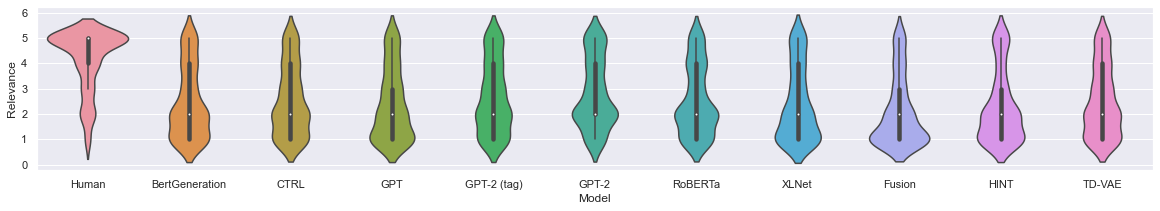

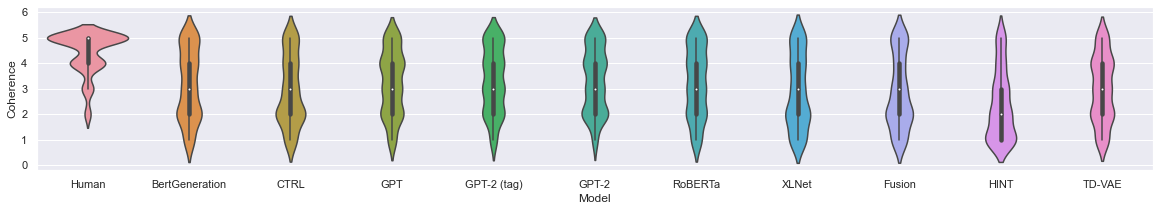

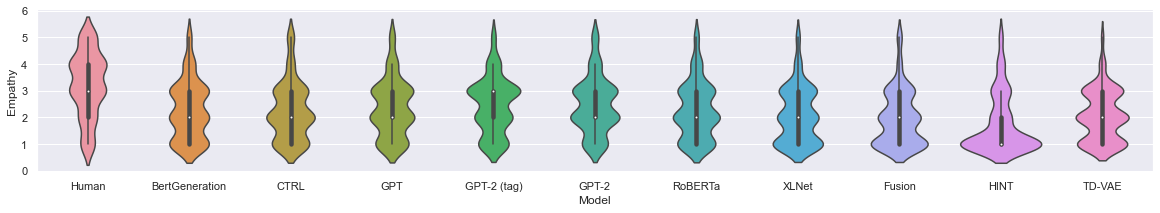

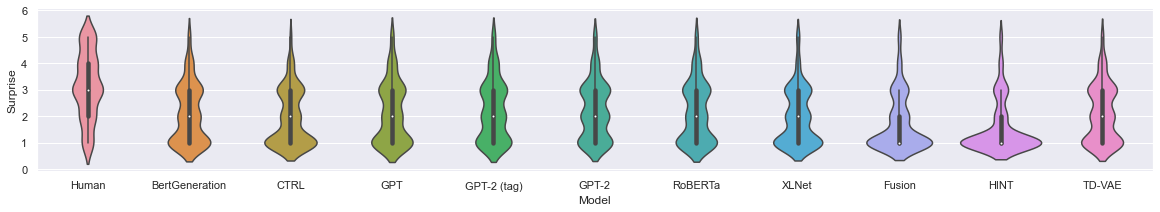

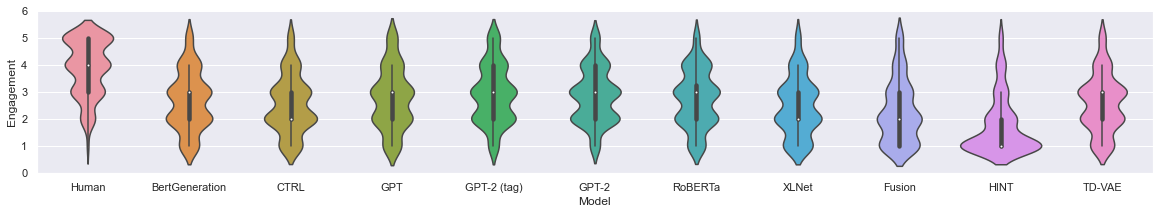

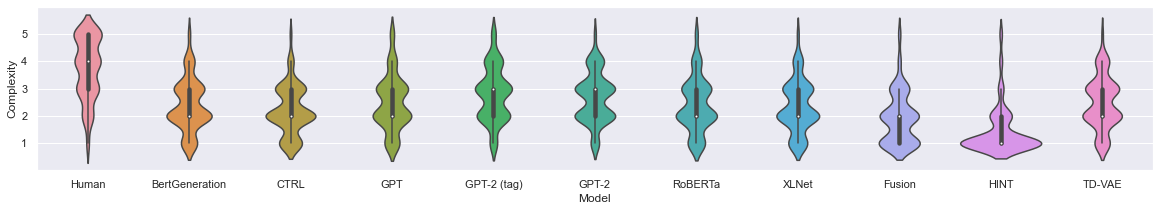

In [120]:
for criterion in CRITERIA:
    sns.set(rc={"figure.figsize":(20, 3)})
    ax = sns.violinplot(x="Model", y=criterion, data=global_df)
    plt.show()

## ICC

In [127]:
for criterion in CRITERIA:
    print("===========================")
    print("Criterion: {}".format(criterion))
    icc = pg.intraclass_corr(data=full_data_df, targets='Story', raters='Judge', ratings=criterion).round(10)
    print(icc.to_markdown())

Criterion: Relevance
|    | Type   | Description             |      ICC |       F |   df1 |   df2 |   pval | CI95%       |
|---:|:-------|:------------------------|---------:|--------:|------:|------:|-------:|:------------|
|  0 | ICC1   | Single raters absolute  | 0.137622 | 1.47875 |  1055 |  2112 |      0 | [0.1  0.18] |
|  1 | ICC2   | Single random raters    | 0.237653 | 2.72061 |  1055 |  2110 |      0 | [0.07 0.39] |
|  2 | ICC3   | Single fixed raters     | 0.364489 | 2.72061 |  1055 |  2110 |      0 | [0.33 0.4 ] |
|  3 | ICC1k  | Average raters absolute | 0.323755 | 1.47875 |  1055 |  2112 |      0 | [0.25 0.39] |
|  4 | ICC2k  | Average random raters   | 0.483262 | 2.72061 |  1055 |  2110 |      0 | [0.18 0.66] |
|  5 | ICC3k  | Average fixed raters    | 0.632435 | 2.72061 |  1055 |  2110 |      0 | [0.59 0.67] |
Criterion: Coherence
|    | Type   | Description             |        ICC |        F |   df1 |   df2 |     pval | CI95%         |
|---:|:-------|:-----------------

# Meta-Evaluation

## Story Level

In [8]:
def get_story_level_correlation(Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, verbose=False):
    """return the story-level correlation between metric1 and metric2"""
    assert Kstr in CORRELATIONS.keys(), "Kstr must be in {}".format(list(CORRELATIONS.keys()))
    K = CORRELATIONS[Kstr]
    if verbose:
        print("K: {}, 1: {}, 2: {}".format(Kstr, metric1, metric2))
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
    data2 = np.array([json.loads(l) for l in df[metric2].tolist()]).T
    x = [K(data1[i], data2[i])[0] for i in range(data1.shape[0]) if not np.isnan(K(data1[i], data2[i])[0])]
    return np.mean(x)

for K in CORRELATIONS.keys():
    print(get_story_level_correlation(K, "BLEU Ξ§", "Relevance", verbose=True))

K: pearson, 1: BLEU Ξ§, 2: Relevance
0.13138144738289825
K: spearman, 1: BLEU Ξ§, 2: Relevance
0.1774777823789897
K: kendall, 1: BLEU Ξ§, 2: Relevance
0.13922033417177257


## System Level

In [9]:
def get_system_level_correlation(Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, verbose=False):
    """return the system-level correlation between metric1 and metric2"""
    assert Kstr in CORRELATIONS.keys(), "Kstr must be in {}".format(list(CORRELATIONS.keys()))
    K = CORRELATIONS[Kstr]
    if verbose:
        print("K: {}, 1: {}, 2: {}".format(Kstr, metric1, metric2))
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
    data2 = np.array([json.loads(l) for l in df[metric2].tolist()]).T
    return K(np.mean(data1, axis=0), np.mean(data2, axis=0))[0]

for K in CORRELATIONS.keys():
    print(get_system_level_correlation(K, "BLEU Ξ§", "Relevance", verbose=True))

K: pearson, 1: BLEU Ξ§, 2: Relevance
0.7988772238903901
K: spearman, 1: BLEU Ξ§, 2: Relevance
0.7212121212121211
K: kendall, 1: BLEU Ξ§, 2: Relevance
0.5555555555555555


## Interface correlation function

In [10]:
def get_correlation(correlation_type, Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, verbose=False, return_length=False):
    """return the system- or story- level correlation between metric1 and metric2"""
    assert correlation_type in CORRELATION_TYPES, "correlation_type must be in {}".format(CORRELATION_TYPES)
    if correlation_type == "system":
        return get_system_level_correlation(Kstr, metric1, metric2, df=df, verbose=verbose)
    elif correlation_type == "story":
        return get_story_level_correlation(Kstr, metric1, metric2, df=df, verbose=verbose)
    else:
        raise ValueError()

## Correlation DataFrame

In [11]:
def get_correlation_df(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA+METRICS, metrics_subset2=None, verbose=False):
    """returns the correlation DataFrame between metrics_subset1 and metrics_subset2,
       or the square correlation DataFrame of metrics_subset1 if metrics_susbet2 is None"""
    SYMMETRIC_DF = metrics_subset2 is None
    I = len(metrics_subset1)
    if SYMMETRIC_DF:
        J = I
        metrics_subset2 = metrics_subset1
    else:
        J = len(metrics_subset2)
    data = np.ones((I, J))
    for i in range(I):
        if SYMMETRIC_DF:
            for j in range(i):
                metric1 = metrics_subset1[i]
                metric2 = metrics_subset2[j]
                data[i][j] = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose)
                data[j][i] = data[i][j]
        else:
            for j in range(J):
                metric1 = metrics_subset1[i]
                metric2 = metrics_subset2[j]
                data[i][j] = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose)
    return pd.DataFrame(data, index=metrics_subset1, columns=metrics_subset2)

In [12]:
get_correlation_df("system", "kendall", df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS_FILTERED)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Relevance,0.555556,0.511111,0.555556,0.600000,0.555556,0.555556,0.600000,-0.422222,-0.555556,0.600000,0.333333,-0.511111,0.511111,-0.333333,-0.288889,0.111111,0.244444
Coherence,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Empathy,0.422222,0.466667,0.422222,0.466667,0.422222,0.511111,0.733333,-0.555556,-0.688889,0.377778,0.200000,-0.377778,0.555556,-0.200000,-0.155556,-0.022222,0.022222
Surprise,0.422222,0.466667,0.511111,0.555556,0.422222,0.511111,0.466667,-0.555556,-0.511111,0.466667,0.288889,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Engagement,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Complexity,0.539360,0.584307,0.629253,0.674200,0.539360,0.629253,0.404520,-0.674200,-0.449467,0.584307,0.404520,-0.314627,0.674200,-0.449467,-0.314627,-0.179787,-0.044947


## Best metrics

In [13]:
def print_best_metrics(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, n_best=5, latex=False, verbose=False):
    """prints the `n_best` best metrics for each criterion for the corresponding `correlation_type` and `Kstr`"""
    corr = get_correlation_df(correlation_type, Kstr, df=df, verbose=verbose)
    for criterion in CRITERIA:
        print(criterion)
        if latex:
            print((100*corr.abs().sort_values(criterion, ascending=False)[criterion].drop(CRITERIA).head(n_best)).round(2).to_latex())
        else:
            print(corr.abs().sort_values(criterion, ascending=False)[criterion].drop(CRITERIA).head(n_best))

In [14]:
print_best_metrics("system", "kendall")

Relevance
S3-Pyramid ΞΔ             0.6
chrF Ξ§                   0.6
ROUGE-SU* Recall Ξ§       0.6
ROUGE-S* Recall Ξ§        0.6
ROUGE-W-1.2 F-Score Ξ§    0.6
Name: Relevance, dtype: float64
Coherence
BaryScore-SD-0.001 Ξε    0.777778
BaryScore-SD-5 Ξε        0.688889
BaryScore-SD-10 Ξε       0.688889
BaryScore-SD-1 Ξε        0.644444
BaryScore-SD-0.5 Ξε      0.600000
Name: Coherence, dtype: float64
Empathy
BaryScore-SD-0.001 Ξε    0.777778
BERTScore F1 Ξε          0.733333
BaryScore-SD-0.01 Ξε     0.733333
MoverScore Ξε            0.733333
BaryScore-W Ξε           0.688889
Name: Empathy, dtype: float64
Surprise
BaryScore-SD-0.001 Ξε    0.777778
BaryScore-SD-5 Ξε        0.688889
BaryScore-SD-10 Ξε       0.688889
BaryScore-SD-1 Ξε        0.644444
Novelty-1 ¤§             0.600000
Name: Surprise, dtype: float64
Engagement
BaryScore-SD-0.001 Ξε    0.777778
BaryScore-SD-5 Ξε        0.688889
BaryScore-SD-10 Ξε       0.688889
BaryScore-SD-1 Ξε        0.644444
BaryScore-SD-0.5 Ξε      0.6000

## Figures

In [15]:
def print_correlation_heatmap(correlation_type, Kstr, df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS,
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None):
    """prints the correlation heatmap"""
    sns.set(font_scale=font_scale)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=figsize)
        corr = (100*get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2)).round().abs()
        if metrics_subset2 is None:
            mask = np.zeros_like(corr)
            mask[np.triu_indices_from(mask, k=1)] = True
            if use_mask:
                ax = sns.heatmap(corr, mask=mask, square=True, annot=True, vmin=0, vmax=100, fmt='g',
                                 xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
            else:
                ax = sns.heatmap(corr, square=True, annot=True, vmin=0, vmax=100, fmt='g',
                                 xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
        else:
            corr.loc['Average'] = corr.mean().round().abs()
            ax = sns.heatmap(corr, annot=True, square=True, vmin=0, vmax=100, fmt='g',
                             xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        if savepath is not None:
            plt.savefig("figures/{}_{}_{}.png".format(savepath, correlation_type, Kstr), bbox_inches='tight')
        else:
            plt.show()
        plt.clf()

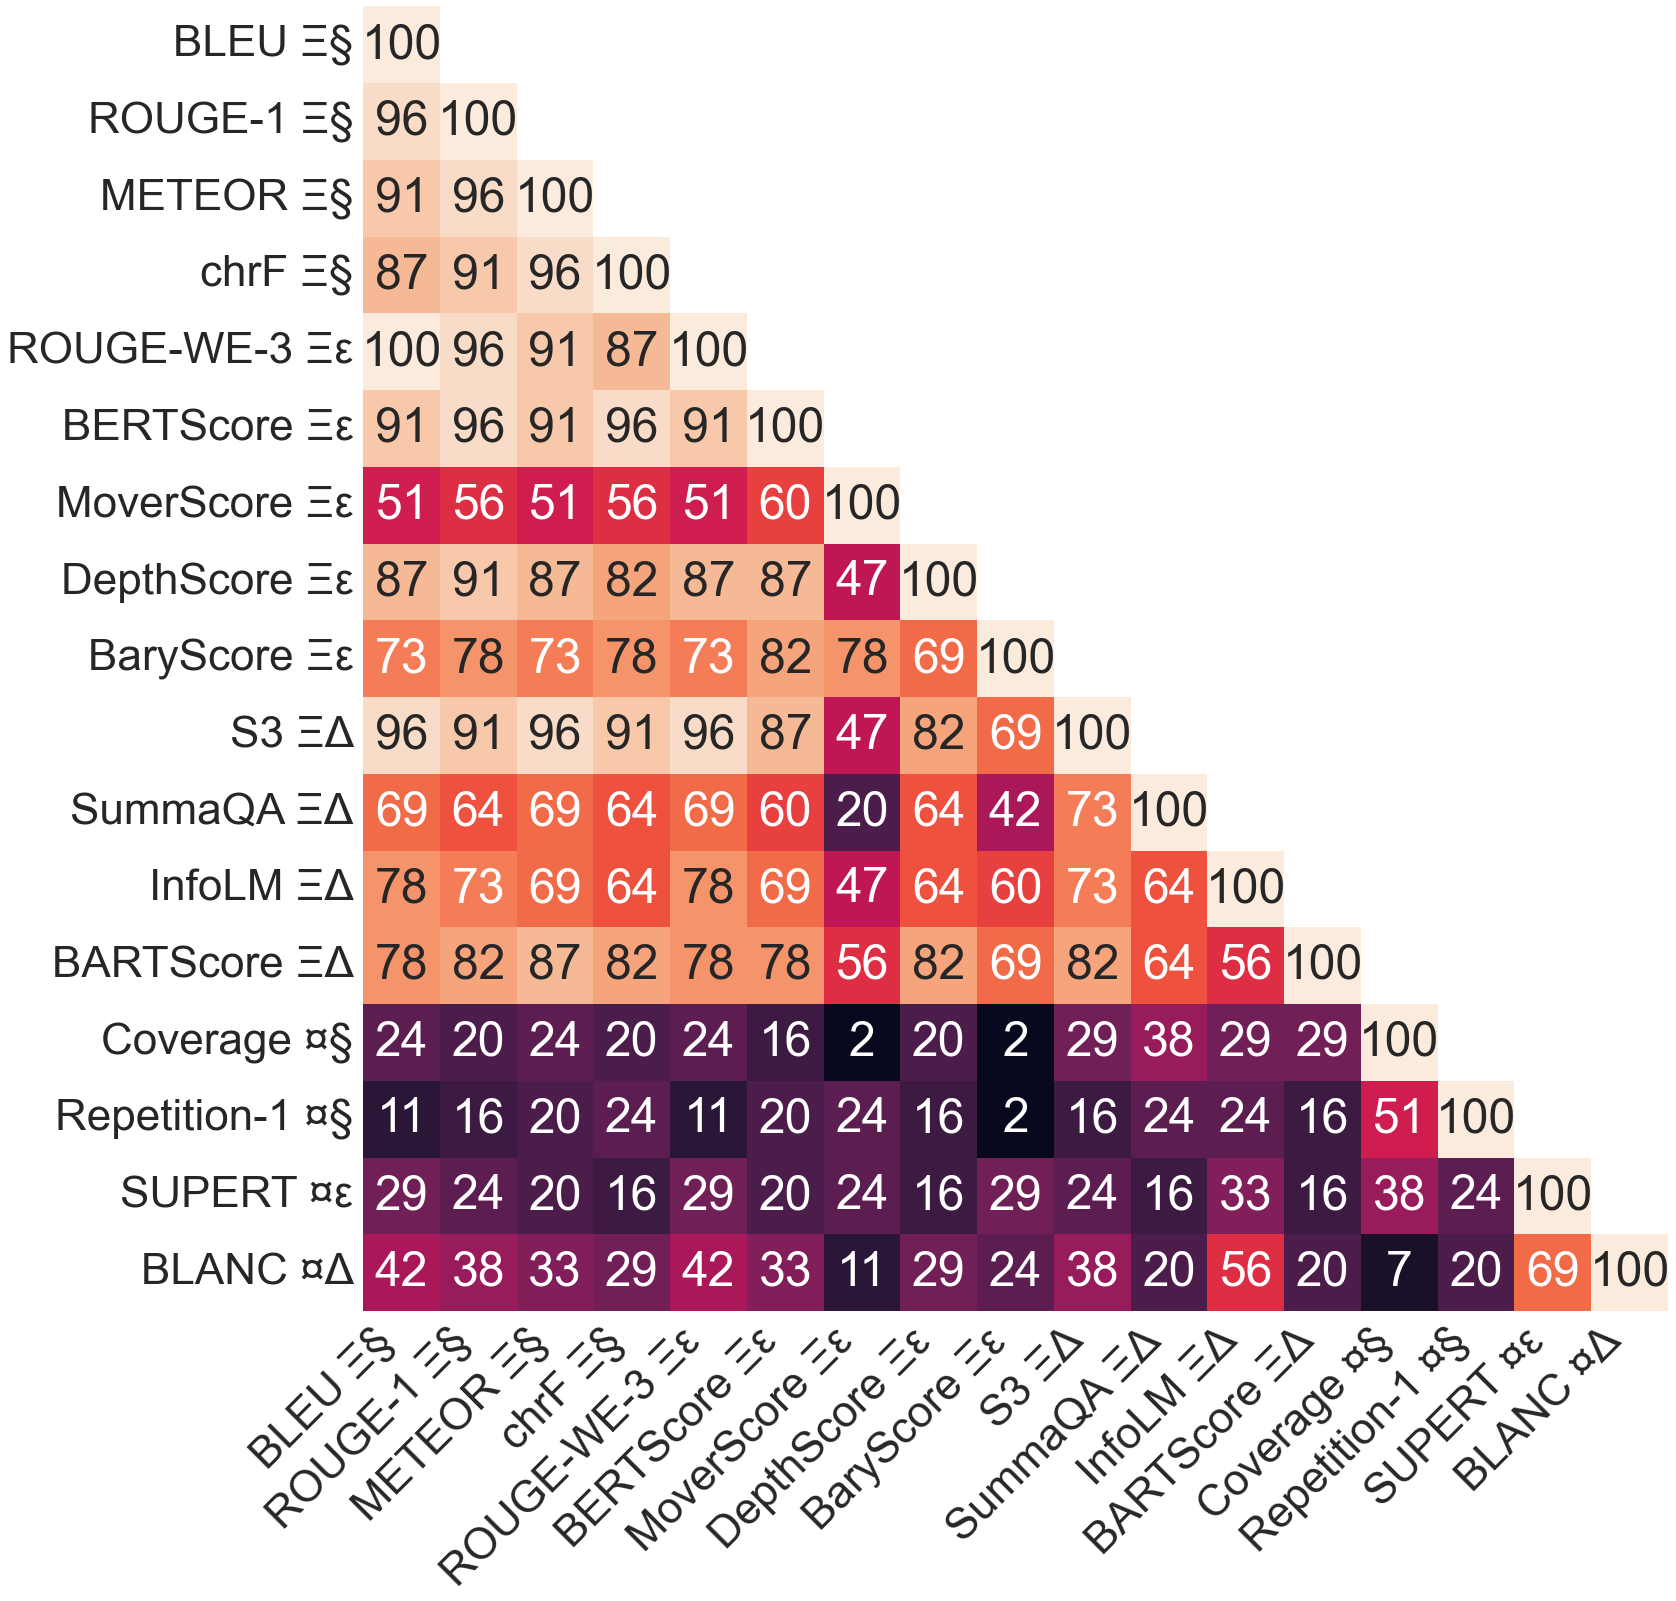

<Figure size 432x288 with 0 Axes>

In [16]:
print_correlation_heatmap("system", "kendall", df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS, 
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None)

In [17]:
# METRICS_FILTERED
METRICS_FILTERED_HEATMAPS_ALL = False
if METRICS_FILTERED_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_FILTERED_DF_NO_HUMAN, 
                                  metrics_subset1=METRICS_FILTERED_LABELS,
                                  metrics_subset2=None,
                                  xticklabels=METRICS_FILTERED_LABELS,
                                  yticklabels=METRICS_FILTERED_LABELS,
                                  use_mask=True, font_scale=4, figsize=(25,24),
                                  savepath=None)

In [18]:
# METRICS
METRICS_HEATMAPS_ALL = False
if METRICS_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=METRICS_LABELS,
                                  metrics_subset2=None,
                                  xticklabels=METRICS_LABELS,
                                  yticklabels=METRICS_LABELS,
                                  use_mask=True, font_scale=2, figsize=(39,40),
                                  savepath=None)

In [19]:
# CRITERIA
CRITERIA_HEATMAPS_ALL = False
if CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=None,
                                  xticklabels=CRITERIA_LABELS,
                                  yticklabels=CRITERIA_LABELS,
                                  use_mask=True, font_scale=2, figsize=(6,5),
                                  savepath=None)

In [20]:
# METRICS_FILTERED and CRITERIA
METRICS_FILTERED_CRITERIA_HEATMAPS_ALL = False
if METRICS_FILTERED_CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=METRICS_FILTERED,
                                  xticklabels=METRICS_FILTERED_LABELS,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=2.5, figsize=(13,5),
                                  savepath=None)

In [21]:
# METRICS and CRITERIA
METRICS_CRITERIA_HEATMAPS_ALL = False
if METRICS_CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=METRICS_LABELS,
                                  xticklabels=METRICS_LABELS,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=1.8, figsize=(30,7),
                                  savepath=None)

## Williams

In [22]:
def get_williams_tp(correlation_type, Kstr, metric1, metric2, metric3, df=METRICS_DF_NO_HUMAN, verbose1=False, verbose2=False):
    """returns the Williams test for the significance of the increase in correlation between r12 and r13"""
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
        
    r12 = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose2)
    r13 = get_correlation(correlation_type, Kstr, metric1, metric3, df=df, verbose=verbose2)
    sign = np.sign(r12) * np.sign(r13)
    r12 = np.abs(r12)
    r13 = np.abs(r13)
    r23 = sign * get_correlation(correlation_type, Kstr, metric2, metric3, df=df, verbose=verbose2)
    
    if correlation_type == "system":
        n = data1.shape[1]
    elif correlation_type == "story":
        n = data1.shape[0]
    else:
        raise ValueError()
    if verbose1:
        print("r12: {}, r13: {}, r23: {}, n: {}".format(r12, r13, r23, n))
    if n <= 3:
        return None, None
    if r12 == r13:
        t, p = None, None
    elif r12 > r13:
        t, p = williams_test(r12, r13, r23, n)
    elif r12 < r13:
        t, p = williams_test(r13, r12, r23, n)
    if verbose1:
        print("1: {}, 2: {}, 3: {}, t: {}, p: {}".format(metric1, metric2, metric3, t, p))
        if p > 0.05:
            print("p > 0.05: not significant increase")
        else:
            print("p < 0.05: significant increase")
    
    return t, p

In [23]:
_ = get_williams_tp("system", "pearson", "Relevance", "BERTScore F1 Ξε", "ROUGE-1 Recall Ξ§", verbose1=True)

r12: 0.69886591627576, r13: 0.7909720918180811, r23: 0.9145073764921343, n: 10
1: Relevance, 2: BERTScore F1 Ξε, 3: ROUGE-1 Recall Ξ§, t: 0.966862495119005, p: 0.1829108619322395
p > 0.05: not significant increase


In [24]:
_ = get_williams_tp("system", "pearson", "Empathy", "BERTScore F1 Ξε", "BLEU Ξ§", verbose1=True)

r12: 0.8867156172959242, r13: 0.7730162713288586, r23: 0.9387296182166223, n: 10
1: Empathy, 2: BERTScore F1 Ξε, 3: BLEU Ξ§, t: 2.00020039909911, p: 0.042797013860609856
p < 0.05: significant increase


In [26]:
def get_williams_matrices(correlation_type, Kstr, metric1, df=METRICS_DF_NO_HUMAN, labels=METRICS, verbose1=False, verbose2=False):
    """returns the matrics containing the Williams test values"""
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
    williams_t = np.zeros((len(labels), len(labels)))
    williams_p = np.zeros((len(labels), len(labels)))    
        
    for i, metric2 in enumerate(labels):
        r12 = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose2)
        for j, metric3 in enumerate(labels[:i]):
            if correlation_type == "system":
                n = data1.shape[1]
            elif correlation_type == "summary":
                n = data1.shape[0]
            else:
                n = np.min([
                        get_correlation(correlation_type, Kstr, metric1, metric2, df=df, return_length=True)[1],
                        get_correlation(correlation_type, Kstr, metric1, metric3, df=df, return_length=True)[1],
                        get_correlation(correlation_type, Kstr, metric2, metric3, df=df, return_length=True)[1]
                    ])
            r13 = get_correlation(correlation_type, Kstr, metric1, metric3, df=df, verbose=verbose2)
            sign = np.sign(r12) * np.sign(r13)
            r12 = np.abs(r12)
            r13 = np.abs(r13)
            r23 = sign * get_correlation(correlation_type, Kstr, metric2, metric3, df=df, verbose=verbose2)
            if verbose1:
                print("{}, {}, {}, {}".format(r12, r13, r23, n))
            if n <= 3:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r12 == r13:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r12 > r13:
                t, p = williams_test(r12, r13, r23, n)
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r13 > r12:
                t, p = williams_test(r13, r12, r23, n)
                williams_t[j][i] = t
                williams_p[j][i] = p
            else:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            if np.isnan(williams_p[i][j]):
                williams_p[i][j] = 0
            if np.isnan(williams_p[j][i]):
                williams_p[j][i] = 0
            if verbose1:
                print("2: {}, 3: {}, t: {}, p: {}".format(metric2, metric3, t, p))
    
    return williams_t, williams_p

In [27]:
def print_significance_heatmap(williams_p, labels=METRICS, font_scale=1.5, figsize=(40,40), save_path=None):
    sns.set(font_scale=font_scale)
    n = len(williams_p)
    fig, ax = plt.subplots(figsize=figsize)   
    eps = 1e-20
    boundaries = [0, eps, 0.05, 1]
    colors = ["#FFFFFF", "#00441B", "#e1fcd6"]
    norm = matplotlib.colors.BoundaryNorm(boundaries=boundaries, ncolors=256)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    annot = np.array([["{}".format(int(np.round(100*williams_p[i][j]))) if not (williams_p[i][j] == 0 or np.isnan(williams_p[i][j])) else "" for j in range(n) ] for i in range(n)])
    mask = np.isnan(williams_p)
    sns.heatmap(pd.DataFrame(williams_p, index=labels[:n], columns=labels[:n]), mask=mask, linewidths=.5, annot=annot, square=True, fmt='', cmap=cmap, norm=norm, cbar=False, ax=ax)
    plt.xticks(rotation=45, ha="right")
    if save_path is None:
        plt.show()
    else:
        fig.savefig(save_path, bbox_inches='tight') 
    plt.clf()

D:\projects\story-evaluation\hanna\williams.py:49: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(2*K*(n-1)/(n-3) + (((r12+r13)**2)/4)*((1-r23)**3))


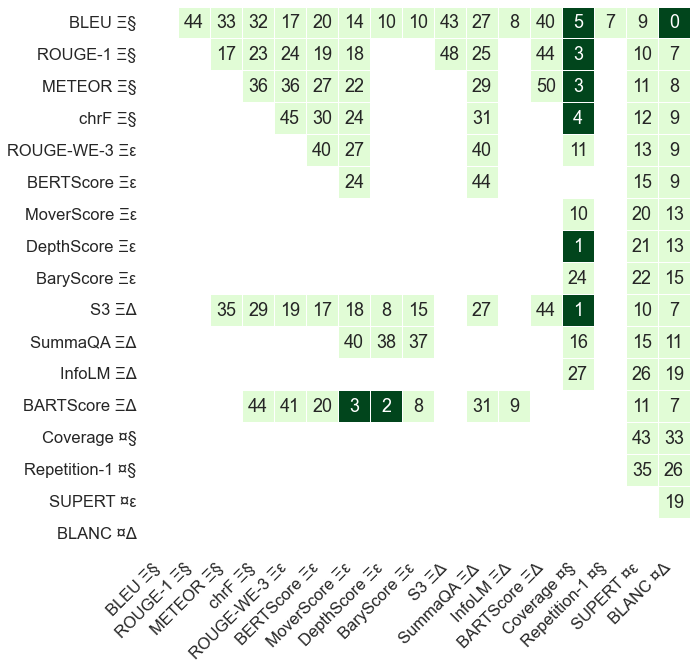

<Figure size 432x288 with 0 Axes>

In [28]:
williams_t, williams_p = get_williams_matrices("system", "pearson", "Relevance", df=METRICS_DF_NO_HUMAN, labels=METRICS_FILTERED, verbose1=False, verbose2=False)
print_significance_heatmap(williams_p, labels=METRICS_FILTERED_LABELS, font_scale=1.5, figsize=(10,10))

In [168]:
WILLIAMS_ALL = False
if WILLIAMS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            for criterion in CRITERIA:
                print(criterion)
                williams_t, williams_p = get_williams_matrices(correlation_type, KStr, criterion, verbose1=False, verbose2=False)
                print_significance_heatmap(williams_p, save_path="figures/williams_{}_{}_{}".format(correlation_type, KStr, criterion))

## Ranking DFs

In [4]:
RESET_RANKINGS = False

In [5]:
if RESET_RANKINGS:        
    df_dict = {}
    for correlation_type in CORRELATION_TYPES:
        for Kstr in CORRELATIONS:
            corr = get_correlation_df(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=METRICS, metrics_subset2=CRITERIA, verbose=False)
            old_columns = corr.columns.copy()
            corr.columns = [t + "_{}_{}".format(correlation_type, Kstr) for t in old_columns]
            df_dict["{}_{}".format(correlation_type, Kstr)] = corr.abs()

In [6]:
if RESET_RANKINGS:
            
    for k in df_dict.keys():
        df_dict[k].to_csv("rankings/{}.csv".format(k), index_label="Model")
        
    for correlation_type in CORRELATION_TYPES:
        correlation_type_df = None
        for k in df_dict.keys():
            if correlation_type in k:
                if correlation_type_df is None:
                    correlation_type_df = df_dict[k]
                else:
                    correlation_type_df = correlation_type_df.join(df_dict[k], lsuffix='_caller', rsuffix='_other')
        correlation_type_df.to_csv("rankings/{}.csv".format(correlation_type), index_label="Model")
    
    for KStr in CORRELATIONS:
        KStr_df = None
        for k in df_dict.keys():
            if KStr in k:
                if KStr_df is None:
                    KStr_df = df_dict[k]
                else:
                    KStr_df = KStr_df.join(df_dict[k], lsuffix='_caller', rsuffix='_other')
        KStr_df.to_csv("rankings/{}.csv".format(KStr), index_label="Model")
        
    for criterion in CRITERIA:
        criterion_df = None
        for k in df_dict.keys():
            if criterion_df is None:
                criterion_df = pd.DataFrame(df_dict[k]["{}_{}".format(criterion, k)])
            else:
                criterion_df = criterion_df.join(pd.DataFrame(df_dict[k]["{}_{}".format(criterion, k)]), lsuffix='_caller', rsuffix='_other')
        criterion_df.to_csv("rankings/{}.csv".format(criterion), index_label="Model")
        
    global_df = None
    for k in df_dict.keys():
        if global_df is None:
            global_df = df_dict[k]
        else:
            global_df = global_df.join(df_dict[k], lsuffix='_caller', rsuffix='_other')
    global_df.to_csv("rankings/{}.csv".format("global"), index_label="Model")

In [7]:
dataframes = os.listdir("rankings")  # remove the folder `.ipynb_checkpoints` is present

In [8]:
def perm_to_rank(systems, mean_rank):
    return [systems[mean_rank.tolist().index(i)] for i in range(len(mean_rank))][::-1]

In [9]:
mean_rankings_dict = {}
one_level_rankings_dict = {}
mean_scores_dict = {}
one_level_scores_dict = {}

for df_name in dataframes:
    df_to_rank = pd.read_csv("rankings/{}".format(df_name))
    systems = list(df_to_rank.Model.values.tolist())
    mean_rank, mean_scores = mean_aggregation_task_level(df_to_rank)
    one_level_rank, one_level_borda_scores = ranking_aggregation(df_to_rank, return_count=True)
    mean_rankings_dict[df_name[:-4]] = perm_to_rank(systems, mean_rank)
    one_level_rankings_dict[df_name[:-4]] = perm_to_rank(systems, one_level_rank)
    mean_scores_dict[df_name[:-4]] = perm_to_rank(mean_scores, mean_rank)
    one_level_scores_dict[df_name[:-4]] = perm_to_rank(one_level_borda_scores, one_level_rank)

In [10]:
def print_rankings(k, ranking_type, topn=5):
    if ranking_type == "mean":
        print(k, list(zip(mean_rankings_dict[k][:topn], mean_scores_dict[k][:topn])))
    elif ranking_type == "one_level":
        print(k, list(zip(one_level_rankings_dict[k][:topn], one_level_scores_dict[k][:topn])))
    else:
        raise ValueError()

In [11]:
print_rankings("system", "one_level")

system [('BARTScore-SH ΞΔ', 1120), ('BaryScore-SD-0.01 Ξε', 1110), ('BERTScore F1 Ξε', 1095), ('MoverScore Ξε', 1070), ('DepthScore Ξε', 1069)]


In [12]:
def print_all_rankings(ranking_type, topn=5):
    print_rankings("global", ranking_type, topn=topn)
    for ctype in CORRELATION_TYPES:
        for KStr in CORRELATIONS:
            print_rankings("{}_{}".format(ctype, KStr), ranking_type, topn=topn)
    for ctype in CORRELATION_TYPES:
        print_rankings(ctype, ranking_type, topn=topn)
    for KStr in CORRELATIONS:
        print_rankings(KStr, ranking_type, topn=topn)
    for criterion in CRITERIA:
        print_rankings(criterion, ranking_type, topn=topn)

In [13]:
PRINT_ONE_LEVEL = True
if PRINT_ONE_LEVEL:
    print_all_rankings("one_level", topn=5)

global [('chrF Ξ§', 2294), ('BARTScore-SH ΞΔ', 2255), ('BERTScore Recall Ξε', 2224), ('S3-Pyramid ΞΔ', 2174), ('S3-Responsiveness ΞΔ', 2133)]
story_pearson [('BERTScore Recall Ξε', 410), ('chrF Ξ§', 408), ('S3-Pyramid ΞΔ', 404), ('S3-Responsiveness ΞΔ', 392), ('ROUGE-1 Recall Ξ§', 389)]
story_spearman [('chrF Ξ§', 415), ('ROUGE-1 Recall Ξ§', 399), ('S3-Pyramid ΞΔ', 397), ('S3-Responsiveness ΞΔ', 395), ('ROUGE-WE-3 Recall Ξε', 392)]
story_kendall [('chrF Ξ§', 414), ('ROUGE-1 Recall Ξ§', 398), ('S3-Pyramid ΞΔ', 397), ('S3-Responsiveness ΞΔ', 390), ('ROUGE-WE-3 Recall Ξε', 389)]
system_pearson [('BARTScore-SH ΞΔ', 403), ('SUPERT-Golden ΞΔ', 388), ('DepthScore Ξε', 386), ('BERTScore F1 Ξε', 381), ('BERTScore Recall Ξε', 381)]
system_spearman [('BaryScore-SD-0.001 Ξε', 393), ('BaryScore-SD-0.01 Ξε', 376), ('chrF Ξ§', 370), ('BaryScore-SD-5 Ξε', 365), ('BERTScore F1 Ξε', 363)]
system_kendall [('BaryScore-SD-0.001 Ξε', 409), ('BaryScore-SD-0.01 Ξε', 378), ('BaryScore-SD-5 Ξε', 374), ('BarySco

In [14]:
PRINT_MEAN = False
if PRINT_MEAN:
    print_all_rankings("mean", topn=5)

# Paired bootstrap test

In [46]:
def bootstrap_test(s1, s2, n, seed=42, df=METRICS_FILTERED_DF_NO_HUMAN, alpha=0.05):
    "returns the bootstrap test for systems 1 and 2"""
    rng = np.random.default_rng(seed)
    scores = np.zeros((len(df.columns), 3))
    for _ in range(n):
        indices = np.random.choice(np.arange(N_STORIES), N_STORIES)
        for i, m in enumerate(df.columns):
            score1 = np.mean(np.array(json.loads(df[m][s1]))[indices])
            score2 = np.mean(np.array(json.loads(df[m][s2]))[indices])
            if score1 > score2:
                scores[i, 0] += 1
            elif score2 > score1:
                scores[i, 1] += 1
            else: 
                scores[i, 2] += 1
    labels = np.zeros(len(df.columns))
    for i, _ in enumerate(df.columns):
        if scores[i, 0] >= (1-alpha) * n:
            labels[i] = 1
        elif scores[i, 1] >= (1-alpha) * n:
            labels[i] = 2
        else:
            labels[i] = 0
    return labels

In [61]:
def global_bootstrap_test(n, seed=42, df=METRICS_FILTERED_DF_NO_HUMAN, metrics=METRICS_FILTERED, alpha=0.05, verbose=False):
    MODELS2 = MODELS[1:]  # remove human from models
    all_labels = np.zeros((int(binom(len(MODELS2), 2)), len(df.columns)))
    pair_i = 0
    for i1, s1 in enumerate(MODELS2):
        for i2, s2 in enumerate(MODELS2[:i1]):
            if verbose:
                print("Pair {} of {}: {} vs {}".format(pair_i+1, int(binom(len(MODELS2), 2)), s1, s2))
            all_labels[pair_i] = bootstrap_test(s1, s2, n, seed=seed, df=df, alpha=alpha)
            pair_i += 1
    fscores = np.zeros((len(CRITERIA), len(metrics)))
    for i in range(len(CRITERIA)):
        for j in range(len(metrics)):
            fscores[i, j] = f1_score(all_labels[:,i], all_labels[:,j+len(CRITERIA)], average="weighted")
    return all_labels, fscores

In [62]:
def print_bootstrap_fscores_heatmap(df=METRICS_FILTERED_DF_NO_HUMAN, metrics=METRICS_FILTERED, 
                                    font_scale=2.5, figsize=(13,5), savepath=None, verbose=False):
    """prints the bootstrap f-scores heatmap"""
    all_labels, fscores = global_bootstrap_test(1000, seed=42, df=df, metrics=metrics, alpha=0.05, verbose=verbose)
    sns.set(font_scale=font_scale)
    fig, ax = plt.subplots(figsize=figsize)
    corr = np.round(100*np.vstack([fscores, np.mean(fscores, axis=0)]))
    ax = sns.heatmap(corr, annot=True, square=True, vmin=0, vmax=100, fmt='g',
                     xticklabels=METRICS_FILTERED_LABELS, yticklabels=CRITERIA_LABELS+["Avg"], cbar=False)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath, bbox_inches='tight')
    return all_labels, fscores

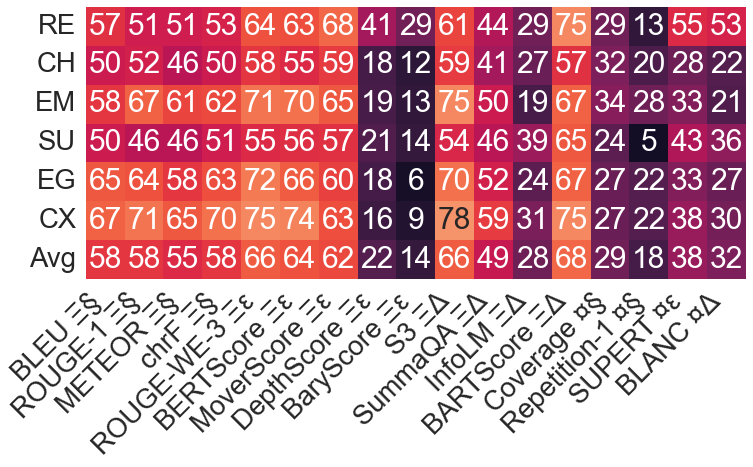

In [63]:
BOOTSTRAP_FILTERED = False
if BOOTSTRAP_FILTERED:
    _, _ = print_bootstrap_fscores_heatmap()

In [64]:
BOOTSTRAP = False
if BOOTSTRAP:
    _, _ = print_bootstrap_fscores_heatmap(df=METRICS_DF_NO_HUMAN, metrics=METRICS, font_scale=1.7, figsize=(30,7))

# Top-k systems

In [80]:
SYSTEM_AVERAGES_DF = full_data_df.groupby(['Model']).mean().round(2)[CRITERIA]
SYSTEM_AVERAGES_DF = SYSTEM_AVERAGES_DF.drop(labels="Human")
SYSTEM_AVERAGES_DF

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity
Model,,,,,,
BertGeneration,2.46,3.14,2.28,2.09,2.67,2.41
CTRL,2.54,2.93,2.26,1.93,2.53,2.23
Fusion,2.09,2.86,1.99,1.72,2.27,1.92
GPT,2.40,3.22,2.37,2.13,2.76,2.49
GPT-2,2.81,3.29,2.47,2.21,2.86,2.68
GPT-2 (tag),2.67,3.31,2.47,2.22,2.92,2.80
HINT,2.29,2.38,1.74,1.56,1.75,1.45
RoBERTa,2.54,3.22,2.27,2.12,2.74,2.41
TD-VAE,2.51,2.99,2.07,2.10,2.59,2.49


In [92]:
def get_correlation_df_topk(k, criterion, correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS, verbose=False):
    """returns the correlation DataFrame between top-k systems"""
    topk_systems = SYSTEM_AVERAGES_DF.sort_values(criterion, ascending=False).index[:k]
    df = df.loc[topk_systems]
    return get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, verbose=verbose)

In [93]:
def analysis_topk(a, b, correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS, verbose=False, step=2, absolute=True):
    """returns the dictionary containing the correlations between criteria and metrics between top-k systems"""
    topk_dict = {}
    k_range = round((b-a)/step)
    for criterion in CRITERIA:
        topk_matrix = np.zeros((k_range, len(metrics_subset2)))
        for i, k in enumerate(range(a, b, step)):
            corr = get_correlation_df_topk(k, criterion, correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, verbose=verbose)
            if absolute:
                corr = corr.abs()
            topk_matrix[i] = corr.loc[criterion]
        topk_dict[criterion] = topk_matrix
    return topk_dict

In [105]:
def facet_plot_topk(a, b, correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                    metrics_subset1=CRITERIA, metrics_subset2=METRICS,
                    step=2, topk_dict=None, absolute=True,
                    savepath=None, verbose=False):
    if topk_dict is None:
        topk_dict = analysis_topk(a, b, correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, verbose=verbose, step=step, absolute=absolute)
    k_range = round((b-a)/step)
    datas = []
    for abbr, criterion in zip(CRITERIA_LABELS, CRITERIA):
        arrays = [
            len(metrics_subset2) * list(range(a,b,step)),
            [metrics_subset2[i//k_range] for i in range(len(metrics_subset2) * k_range)],
            len(metrics_subset2) * k_range * [abbr]
        ]
        df_index = pd.MultiIndex.from_arrays(arrays, names=('k', 'metric', 'criterion'))
        data = pd.DataFrame(topk_dict[criterion].T.flatten(), index=df_index, columns=['r'])
        data.reset_index(inplace=True)
        datas.append(data)
    plot_df = pd.concat(datas, ignore_index=True)
    sns.set(font_scale=2.3)
    pl = sns.relplot(
        data=plot_df,
        x="k", y="r", 
        hue="metric", col="criterion",
        style="metric",
        kind="line", palette="deep",
        markers=8*["o"], dashes=False
    )
    if absolute:
        pl.set(
            yticks=[0, 0.25, 0.5, 0.75, 1],
            xticks=[4,6,8,10]
        )
    else:
        pl.set(
            yticks=[-1, -0.5, 0, 0.5, 1],
            xticks=[4,6,8,10]
        )
    (pl.set_titles("{col_name}").tight_layout(w_pad=0.8))
    sns.move_legend(pl, "lower center", bbox_to_anchor=(0.445, -0.1), ncol=8, title=None, frameon=False)
    plt.ylabel("r", rotation=90)
    plt.xlim(10, 4)
    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath, bbox_inches='tight')
    return plot_df

In [106]:
METRICS_FILTERED_LABELS2 = [
    "BLEU Ξ§", "ROUGE-1 Ξ§", "chrF Ξ§", "BERTScore Ξε", "BaryScore Ξε", "S3 ΞΔ", "BARTScore ΞΔ", "SUPERT ¤ε"
]

METRICS_FILTERED_DF_NO_HUMAN2 = METRICS_FILTERED_DF_NO_HUMAN[CRITERIA + METRICS_FILTERED_LABELS2]

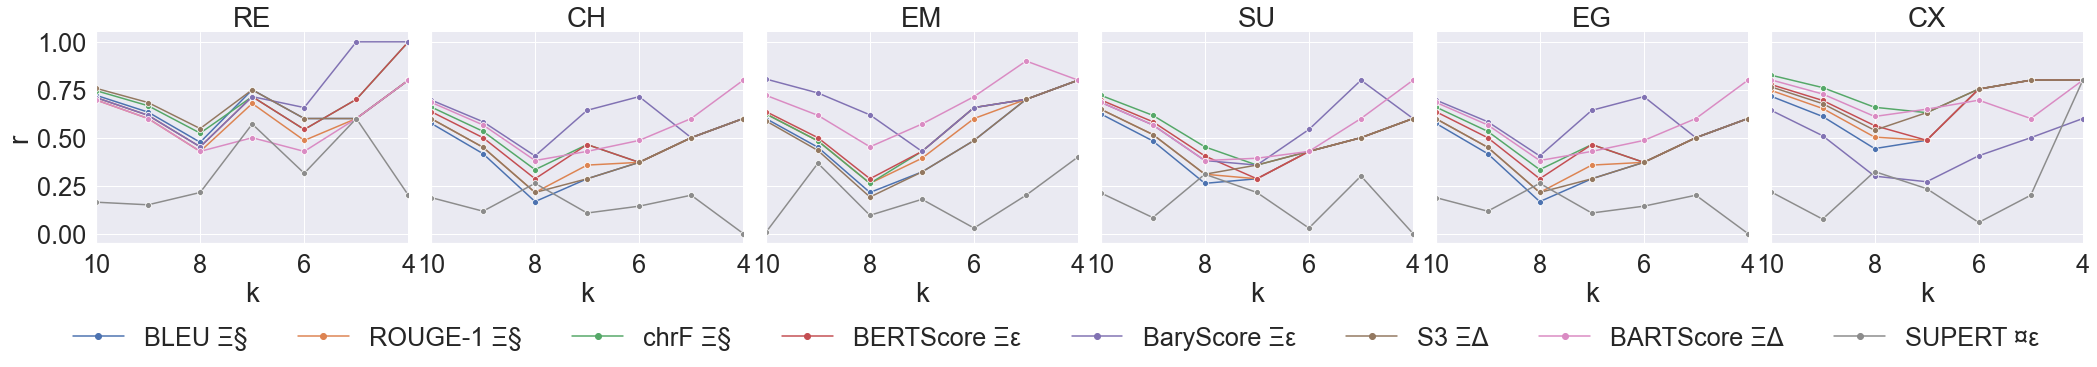

,k,metric,criterion,r
0,4,BLEU Ξ§,RE,0.800000
1,5,BLEU Ξ§,RE,0.600000
2,6,BLEU Ξ§,RE,0.600000
3,7,BLEU Ξ§,RE,0.750000
4,8,BLEU Ξ§,RE,0.476190
...,...,...,...,...
331,6,SUPERT ¤ε,CX,0.057977
332,7,SUPERT ¤ε,CX,0.234244
333,8,SUPERT ¤ε,CX,0.323359
334,9,SUPERT ¤ε,CX,0.075314


In [107]:
facet_plot_topk(4, 11, "system", "spearman", df=METRICS_FILTERED_DF_NO_HUMAN2, metrics_subset1=CRITERIA, metrics_subset2=METRICS_FILTERED_LABELS2, verbose=False, step=1)